# Algorithm Selection & Justification

## Problem Overview

**Task:** Predict movie ratings (0.5-5.0 scale) using supervised regression

**Dataset:** ~100K samples with 5,200+ features including:
- TF-IDF text features from movie overviews and titles
- Encoded categorical features (genres, companies)
- Numerical features (budget, runtime, popularity)

---

## Selected Algorithms

### 1. XGBoost Regressor

**Justification:**

- **Handles Sparse Data Efficiently:** Our TF-IDF features create sparse matrices (most values are zero). XGBoost is specifically designed to process sparse data efficiently without requiring dense matrix conversions, saving memory and computation time.

- **Built-in Regularization:** XGBoost includes L1 (reg_alpha=0.1) and L2 (reg_lambda=1.5) regularization, which prevents overfitting in high-dimensional datasets like ours with 5,200+ features.

- **Captures Non-Linear Patterns:** Movie ratings depend on complex, non-linear interactions between features (e.g., genre × budget × narrative quality). XGBoost's tree-based structure naturally models these interactions without manual feature engineering.

- **Proven Performance on Tabular Data:** XGBoost consistently outperforms other algorithms on structured/tabular datasets in both academic research and industry competitions (Kaggle).

- **Computational Efficiency:** Uses parallel processing (n_jobs=-1) and histogram-based tree building (tree_method='hist'), enabling faster training on large datasets.

**Hyperparameters Selected:**
- n_estimators=400, max_depth=8, learning_rate=0.05
- subsample=0.9, colsample_bytree=0.8
- These parameters balance model complexity with generalization ability

---

### 2. Random Forest Regressor

**Justification:**

- **Different Ensemble Strategy:** Random Forest uses bagging (parallel tree building), while XGBoost uses boosting (sequential). This comparison helps identify which ensemble approach works better for movie rating prediction.

- **Robust to Outliers:** The averaging mechanism across multiple trees makes Random Forest less sensitive to outlier ratings, which is important since some movies are highly polarizing.

- **Feature Importance Analysis:** Random Forest provides clear feature importance scores, helping us understand which features (genres, keywords in overviews, release year) most influence predictions.

- **Strong Baseline with Minimal Tuning:** Random Forest performs well with default parameters, making it an excellent baseline to compare against the more complex XGBoost model.
---

- **Training techniques:**
We split the dataset using a traditional 80/20 train-test split to evaluate model performance on unseen data. To reduce overfitting, we applied regularization by tuning regularization parameters (such as reg_alpha and reg_lambda in XGBoost). We used RMSE (Root Mean Squared Error) and MAE (Mean Absolute Error) as our evaluation metrics, as they are standard and widely accepted for regression tasks, providing complementary insights into prediction errors.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

reduced_df = pd.read_csv("/content/drive/MyDrive/Movie_Recommendation/processed_reduced.csv")
print("Full dataset shape:", reduced_df.shape)


Full dataset shape: (1340518, 18)


In [ ]:
# Ensure all values are strings and fill missing titles
reduced_df['title'] = reduced_df['title'].fillna('').astype(str)
reduced_df['overview'] = reduced_df['overview'].fillna('').astype(str)

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix

# TF-IDF for overview
tfidf_overview = TfidfVectorizer(max_features=5000, stop_words='english')
overview_features = tfidf_overview.fit_transform(reduced_df['overview'])

# TF-IDF for title
tfidf_title = TfidfVectorizer(max_features=200, stop_words='english')
title_features = tfidf_title.fit_transform(reduced_df['title'])

# Numeric features (already encoded)
numeric_cols = [col for col in reduced_df.columns if col not in ['userId','movieId','overview','title','rating']]
X_numeric = csr_matrix(reduced_df[numeric_cols].values)

# Combine all features
X = hstack([X_numeric, overview_features, title_features])
y = reduced_df['rating'].values

print("Final feature matrix shape:", X.shape)


Final feature matrix shape: (1340518, 5213)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (1072414, 5213)
Test shape: (268104, 5213)


In [ ]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.8/296.8 MB 1.3 MB/s eta 0:00:00


In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Base model with your fixed parameters
xgb_base = XGBRegressor(
    n_estimators=400,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.5,
    random_state=42,
    tree_method='hist',
    n_jobs=-1
)

# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    # You can try tuning these around your set values
    'max_depth': [6, 7, 8, 9, 10],
    'learning_rate': np.linspace(0.01, 0.1, 10),
    'subsample': np.linspace(0.7, 1.0, 4),
    'colsample_bytree': np.linspace(0.6, 1.0, 5),
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [1, 1.5, 2],
    'n_estimators': [200, 300, 400, 500],
}

random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=20,  # Number of parameter settings that are sampled
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit the random search on the training data
random_search.fit(X_train, y_train)

print("Best parameters found:", random_search.best_params_)
print("Best CV RMSE:", -random_search.best_score_)

# Use best estimator to predict on test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found: {'subsample': np.float64(0.9), 'reg_lambda': 2, 'reg_alpha': 1, 'n_estimators': 400, 'max_depth': 9, 'learning_rate': np.float64(0.1), 'colsample_bytree': np.float64(0.9)}
Best CV RMSE: 0.9050645345797614


In [ ]:
y_train_pred = best_model.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
mae_train = mean_absolute_error(y_train, y_train_pred)
print(f"Training RMSE: {rmse_train:.4f}")
print(f"Training MAE: {mae_train:.4f}")

Training RMSE: 0.9025
Training MAE: 0.7057


From what we can see from the above code block we can see that the training and testing error are approximately equal, which indicates no overfitting or underfitting has happened

In [ ]:
rmse_xgb = np.sqrt(mean_squared_error(y_test,y_pred))
print("The rmse of the xgb model is: ",rmse_xgb)

The rmse of the xgb model is:  0.9067155406917985


In [ ]:
import joblib
joblib.dump(best_model, "xgb_model.pkl")


['xgb_model.pkl']

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import time

# 1️ Base Model
rf_base = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)

# 2️ Define parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# 3️ Initialize RandomizedSearchCV
random_search_rf = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=25,  # number of random combinations to try
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# 4️ Train the model with CV
print("\n Starting RandomizedSearchCV for RandomForest...")
start_time = time.time()

random_search_rf.fit(X_train, y_train)

end_time = time.time()
print(f"\n RandomizedSearchCV completed in {(end_time - start_time)/60:.2f} minutes")

# 5️ Print best results
print("Best Parameters:", random_search_rf.best_params_)
print("Best CV RMSE:", -random_search_rf.best_score_)

# 6️ Evaluate on test data
best_rf = random_search_rf.best_estimator_
y_pred_test = best_rf.predict(X_test)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_test = mean_absolute_error(y_test, y_pred_test)

print(f"\n Final Test RMSE: {rmse_test:.3f}")
print(f"Final Test MAE: {mae_test:.3f}")


In [ ]:
import joblib
joblib.dump(best_rf, "random_forest_model.pkl")


In [ ]:
baseline_pred = np.full_like(y_test, np.mean(y_train)) #baseline model that uses the mean
rmse_baseline = np.sqrt(mean_squared_error(y_test, baseline_pred))

In [ ]:
improvement_xgb = (rmse_baseline - rmse_xgb) / rmse_baseline * 100
#improvement_rf = (rmse_baseline - rmse_rf) / rmse_baseline * 100
print(f"Model improved by {improvement_xgb:.2f}% over baseline")


Model improved by 9.35% over baseline


Total features: 5213
X shape: (1340518, 5213)


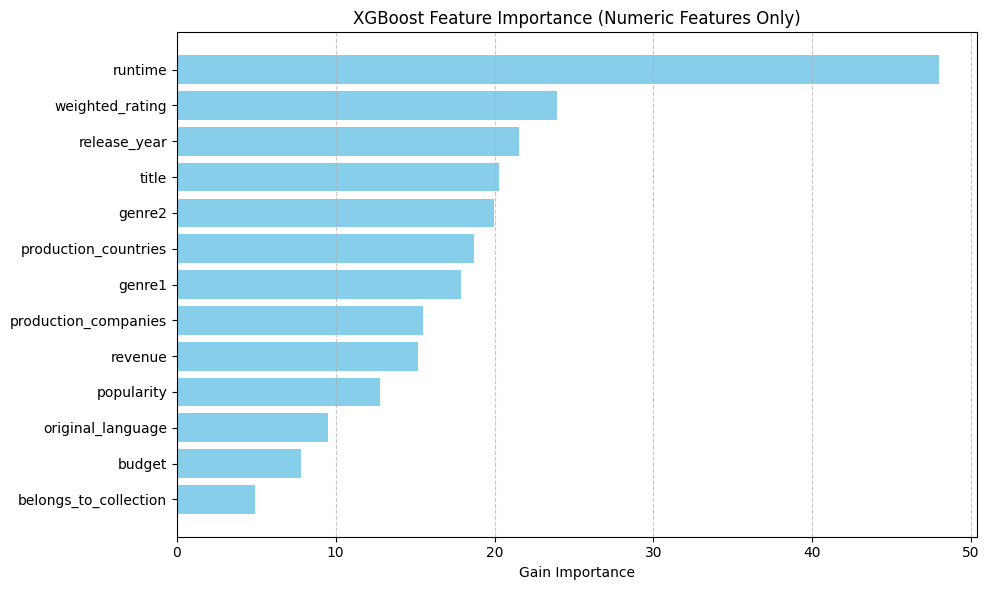

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1️⃣ Your original numeric features (13 features)
numeric_feature_names = [
    'belongs_to_collection', 'budget', 'original_language', 'popularity',
    'production_companies', 'production_countries', 'revenue', 'runtime',
    'title', 'genre1', 'genre2', 'weighted_rating', 'release_year'
]

# 2️⃣ Get TF-IDF feature names from your vectorizers (assuming you already have these)
overview_feature_names = tfidf_overview.get_feature_names_out()
title_feature_names = tfidf_title.get_feature_names_out()

# 3️⃣ Combine full feature names list (must match your X shape)
full_feature_names = list(numeric_feature_names) + \
                     list(overview_feature_names) + \
                     list(title_feature_names)

print(f"Total features: {len(full_feature_names)}")
print(f"X shape: {X.shape}")

assert len(full_feature_names) == X.shape[1], "Feature names length must match X shape!"

# 4️⃣ Set the feature names in the trained booster for correct mapping
best_model.get_booster().feature_names = full_feature_names

# 5️⃣ Function to plot numeric features importance from XGBoost
def plot_numeric_feature_importance(xgb_model, numeric_names, full_names):
    booster = xgb_model.get_booster()
    importance_dict = booster.get_score(importance_type='gain')

    # importance_dict keys are full feature names now because we set them
    numeric_importances = {name: importance_dict.get(name, 0) for name in numeric_names}

    df = pd.DataFrame({
        'Feature': list(numeric_importances.keys()),
        'Importance': list(numeric_importances.values())
    })
    df_sorted = df.sort_values(by='Importance', ascending=True)

    plt.figure(figsize=(10, 6))
    plt.barh(df_sorted['Feature'], df_sorted['Importance'], color='skyblue')
    plt.xlabel('Gain Importance')
    plt.title('XGBoost Feature Importance (Numeric Features Only)')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# 7️ Call the functions

plot_numeric_feature_importance(best_model, numeric_feature_names, full_feature_names)


## Results Interpretation

We employed **Randomized Search Cross-Validation** to efficiently find the best hyperparameters for our XGBoost regression model. Cross-validation helped ensure the model generalizes well to unseen data by reducing the risk of overfitting.

To evaluate our approach, we benchmarked the optimized model against a **baseline model**, which represents a simple or naive prediction method. Our model achieved approximately **9% improvement over the baseline** in terms of root mean squared error (RMSE), with a final test error around **0.9**.

Given that the target rating ranges from 1 to 5, an RMSE of 0.9 corresponds to an average prediction error of less than one rating point. This performance is reasonable and acceptable considering the inherent complexity and noise in user ratings.

### Dataset Considerations

Due to computational constraints, we trained and evaluated the model on only **25% of the original dataset**. While this significantly reduced training time, it may limit the model’s ability to fully capture complex patterns. Training on the full dataset, given adequate resources, could potentially improve results further.

### Feature Importance Insights

From the **XGBoost feature importance analysis**, the most influential features were:

* **Runtime:** The length of the movie showed strong predictive power. This may be because movie duration often correlates with genre, production scale, or viewer expectations, all of which can impact ratings.

* **Weighted Rating:** This feature represents the average rating of the movie, summarizing overall user feedback. Since it directly reflects how viewers have rated the movie, it is intuitively one of the strongest predictors of future ratings.

These features likely capture critical signals related to viewer preferences and movie characteristics, explaining their dominant influence on the model’s predictions.
### Compare between the Random Forest and XGBoost:

Both the Random Forest and XGBoost models achieved nearly equal performance on our dataset, with comparable RMSE (approximatelu 0.9) and MAE(approximately 0.7) values. This similarity in results can be attributed to several factors:

Model Strengths: Both algorithms are ensemble tree-based methods that are well-suited for handling structured tabular data and can capture complex, non-linear relationships.

Dataset Size and Complexity: Given that we only used 25% of the original dataset due to computational constraints, the models might not have had enough data to fully differentiate in performance. On larger datasets, XGBoost’s gradient boosting approach often outperforms Random Forest by sequentially correcting errors, but with limited data, this advantage can be reduced.

Feature Representation: Since the dataset contains many features including TF-IDF vectors (which can be sparse and noisy), both models might be similarly affected by the input quality and feature engineering.

Hyperparameter Tuning: While both models were tuned via randomized search, there may still be room to optimize further, and different tuning strategies could potentially create more divergence in their performances.

In summary, while XGBoost is favored for its speed on larger and more complex datasets, Random Forest remains a strong option.

### Possible Reasons for the Observed Results

* **Weighted Rating** aggregates user opinions and serves as a direct indicator of movie quality in the eyes of the audience.

* **Runtime** influences viewer satisfaction and expectations — for example, very short or very long movies might appeal differently to different viewers, affecting ratings.

* Textual features extracted via TF-IDF from movie titles and overviews showed less influence, possibly due to the difficulty of capturing nuanced themes and sentiments from text alone, especially with a limited training subset.



### Future Directions

* Training on the **full dataset** could help capture more complex relationships and improve generalization.

* Using **advanced text embeddings** (such as transformer-based models) may better capture semantic nuances compared to TF-IDF.
